# 0. 사용할 패키지 불러오기

In [1]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D
from tensorflow.python.keras.layers.convolutional import MaxPooling2D
from tensorflow.python.keras.layers.core import Activation
from tensorflow.python.keras.layers.core import Flatten
from tensorflow.python.keras.layers.core import Dropout
from tensorflow.python.keras.layers.core import Dense
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.python.keras.models import load_model

# 1. 데이터 불러오기

In [2]:
import numpy as np
import glob
import sys
from sklearn.model_selection import train_test_split

x_train = np.empty((0, 180, 240, 3))
y_train = np.empty((0, 3))
print(y_train.shape)

training_data = glob.glob('/home/pirl/Desktop/motion_prepro_fin2/*.npz')
#print(training_data)
idx=1
for single_npz in training_data:
    with np.load(single_npz) as data:
        #print(data.files)
        x = data['train']
        y = data['training_labels']
        print(x.shape, y.shape)
    x = np.reshape(x, (-1, 180, 240, 3))
    y_temp=np.empty((0,3))
    for i in range(1000):
        y_temp=np.vstack((y_temp,y))
        
    x_train = np.vstack((x_train, x))
    y_train = np.vstack((y_train, y_temp))
    #print(idx)
    idx+=1
print(x_train.shape)
#train test split, 7:3
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3, random_state = 42)

y_train = y_train[:,:]
y_test = y_test[:,:]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(0, 3)
(1000, 180, 240, 3) (3,)
(1000, 180, 240, 3) (3,)
(1000, 180, 240, 3) (3,)
(3000, 180, 240, 3)
(2100, 180, 240, 3) (2100, 3)
(900, 180, 240, 3) (900, 3)


# 데이터 확인

In [3]:
#import pandas as pd

#y_data = pd.DataFrame(y_total[:, :])

In [4]:
#y_data.count()

In [5]:
#left = y_data.loc[y_data[:][0] == 1]

In [6]:
#left.count()

In [7]:
#right = y_data.loc[y_data[:][1] == 1]

In [8]:
#right.count()

In [9]:
#forward = y_data.loc[y_data[:][2] == 1]

In [10]:
#forward.count()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

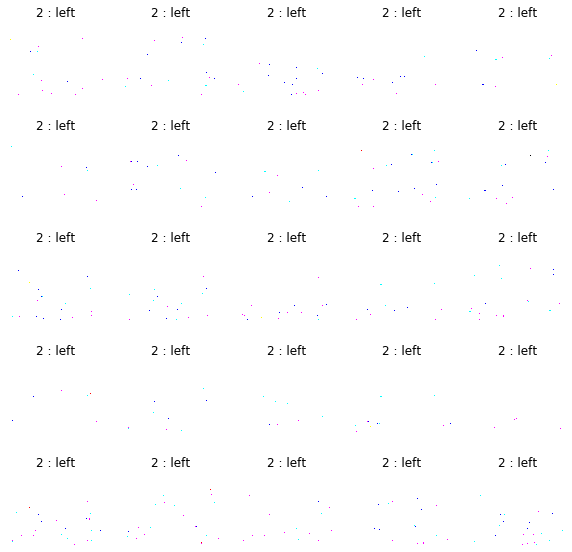

In [11]:
# 데이터 확인

from matplotlib import pyplot as plt
%matplotlib inline

plt_row = 5
plt_col = 5
plt.rcParams["figure.figsize"] = (10,10)

f, axarr = plt.subplots(plt_row, plt_col)

for i in range(plt_row*plt_col):
    #print(x_train[i])
    sub_plt = axarr[int(i/plt_row), int(i%plt_col)]
    sub_plt.axis('off')
    sub_plt.imshow(x_train[i].reshape(180, 240,3))
    
    label = np.argmax(y_train)
                      
    if label == 2 :
        direction = 'left'
    elif label == 1:
        direction = 'right'
    elif label == 0:
        direction = 'forward'
#     elif label == 3:
#         direction = 'backward'
                      
    sub_plt_title = str(label) + " : " + direction
    sub_plt.set_title(sub_plt_title)

plt.show()

# 3. 모델 생성

In [12]:
# image size = 160 x 320
def posla_net():
    
    # model setting
    H = 180
    W = 240
    CH = 3

    inputShape = (H, W, CH)

    activation = 'relu'
    keep_prob_conv = 0.25
    keep_prob_dense = 0.5

    #init = 'glorot_normal'
    #init = 'he_normal'
    init = 'he_uniform'
    chanDim = -1
    classes = 3
    
    model = Sequential()
    
    # CONV => RELU => POOL
    model.add(Conv2D(3, (3, 3), padding="valid", input_shape=inputShape, kernel_initializer=init, activation=activation))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(9, (3, 3), padding="valid", kernel_initializer=init, activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(18, (3, 3), padding="valid", kernel_initializer=init, activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, (3, 3), padding="valid", kernel_initializer=init, activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(80, kernel_initializer=init, activation=activation))
    model.add(Dropout(keep_prob_dense))
    
    model.add(Dense(15, kernel_initializer=init, activation=activation))
    model.add(Dropout(keep_prob_dense))
    
    # softmax classifier
    model.add(Dense(classes , activation = 'softmax'))
    
    return model

In [13]:
model = posla_net()
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 178, 238, 3)       84        
_________________________________________________________________
batch_normalization (BatchNo (None, 178, 238, 3)       12        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 119, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 117, 9)        252       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 58, 9)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 56, 18)        1476      
_________________________________________

In [14]:
from tensorflow.python.keras.utils import plot_model
plot_model(model, to_file= 'video_net_plot.png', show_shapes = True, show_layer_names = True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


# 4. 모델 파라미터 셋팅

적은 수의 이미지 데이터가 존재할 경우 데이터를 늘리는 용도로 사용

In [15]:
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [17]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)

In [18]:
# initialize the model
# EPOCHS = 50
# INIT_LR = 1e-3
# BS = 32
# split_ratio = 0.2

In [19]:
EPOCHS = 50
INIT_LR = 1e-4
BS = 256
split_ratio = 0.2

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])
 

[INFO] compiling model...


# 5. 모델 훈련

In [20]:
from tensorflow.keras.utils import to_categorical


In [21]:
y_binary = to_categorical(y_train)

In [22]:

hist = model.fit(x_train, y_train, 
                 epochs=EPOCHS, batch_size=BS, 
                 validation_split=split_ratio, 
                 verbose = 1
                 ,callbacks=[reduce_lr]
                )

Train on 1680 samples, validate on 420 samples
Epoch 1/50
1680/1680 [==============================] - 25s 15ms/sample - loss: 2.8228 - acc: 0.3696 - val_loss: 1.1518 - val_acc: 0.4929
Epoch 2/50
1680/1680 [==============================] - 24s 14ms/sample - loss: 1.2668 - acc: 0.4744 - val_loss: 0.8771 - val_acc: 0.5667
Epoch 3/50
1680/1680 [==============================] - 24s 14ms/sample - loss: 0.9861 - acc: 0.5685 - val_loss: 0.2542 - val_acc: 0.9143
Epoch 4/50
1680/1680 [==============================] - 23s 14ms/sample - loss: 0.7501 - acc: 0.6321 - val_loss: 0.1604 - val_acc: 0.9881
Epoch 5/50
1680/1680 [==============================] - 24s 14ms/sample - loss: 0.6027 - acc: 0.7155 - val_loss: 0.1130 - val_acc: 0.9929
Epoch 6/50
1680/1680 [==============================] - 24s 14ms/sample - loss: 0.5520 - acc: 0.7429 - val_loss: 0.0812 - val_acc: 0.9952
Epoch 7/50
1680/1680 [==============================] - 25s 15ms/sample - loss: 0.5277 - acc: 0.7649 - val_loss: 0.0839 - val

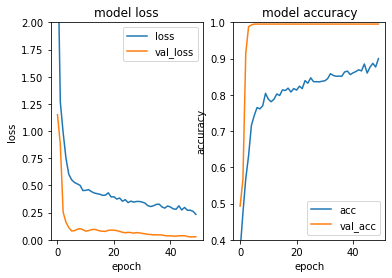

In [23]:
plt.subplot(1, 2, 1)
plt.title('model loss')
plt.plot(hist.history['loss'], label="loss")
plt.plot(hist.history['val_loss'], label="val_loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.ylim((0,2))

plt.subplot(1, 2, 2)
plt.title('model accuracy')
plt.plot(hist.history['acc'], label="acc")
plt.plot(hist.history['val_acc'], label="val_acc")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.ylim((0.4, 1))


plt.show();

# 6. 모델 결과 확인

In [31]:
#l_model = load_model('./model_data/VGG_model.h5')

In [24]:
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=BS)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

900/900 [==============================] - 5s 5ms/sample - loss: 0.0269 - acc: 0.9978
## evaluation loss and_metrics ##
[0.026867600174413787, 0.99777776]


In [25]:
xhat_idx = np.random.choice(x_test.shape[0], 10)
xhat = x_test[xhat_idx]

yhat_classes = model.predict_classes(xhat)

for i in range(10):
    print('True : ' + str(np.argmax(y_test[xhat_idx[i]])) + ', Predict : ' + str(yhat_classes[i]))

True : 0, Predict : 0
True : 0, Predict : 0
True : 0, Predict : 0
True : 1, Predict : 1
True : 1, Predict : 1
True : 2, Predict : 2
True : 2, Predict : 2
True : 0, Predict : 0
True : 1, Predict : 1
True : 1, Predict : 1


# 7. 최종 모델 훈련

In [26]:
x_total = np.vstack((x_train, x_test))
y_total = np.vstack((y_train, y_test))

print(x_total.shape)
print(y_total.shape)

(3000, 180, 240, 3)
(3000, 3)


In [27]:
early_stopping = EarlyStopping(monitor='loss', patience=10)

In [28]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=0.0001)

In [29]:
EPOCHS = 50
INIT_LR = 1e-4
BS = 256
split_ratio = 0.2

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])

[INFO] compiling model...


In [30]:
hist = model.fit(x_total, y_total, 
                 epochs=EPOCHS, batch_size=BS, 
                 #validation_split=split_ratio, 
                 verbose = 1
                 ,callbacks=[reduce_lr]
                )

Train on 3000 samples
Epoch 1/50
3000/3000 [==============================] - 42s 14ms/sample - loss: 0.2829 - acc: 0.8723
Epoch 2/50
3000/3000 [==============================] - 40s 13ms/sample - loss: 0.2611 - acc: 0.8727
Epoch 3/50
3000/3000 [==============================] - 41s 14ms/sample - loss: 0.2531 - acc: 0.8873
Epoch 4/50
3000/3000 [==============================] - 40s 13ms/sample - loss: 0.2678 - acc: 0.8700
Epoch 5/50
3000/3000 [==============================] - 40s 13ms/sample - loss: 0.2304 - acc: 0.8900
Epoch 6/50
3000/3000 [==============================] - 40s 13ms/sample - loss: 0.2368 - acc: 0.8877
Epoch 7/50
3000/3000 [==============================] - 40s 13ms/sample - loss: 0.2255 - acc: 0.8947
Epoch 8/50
3000/3000 [==============================] - 41s 14ms/sample - loss: 0.2243 - acc: 0.8963
Epoch 9/50
3000/3000 [==============================] - 40s 13ms/sample - loss: 0.2116 - acc: 0.8963
Epoch 10/50
3000/3000 [==============================] - 40s 13ms/sam

In [31]:
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=BS)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

900/900 [==============================] - 5s 5ms/sample - loss: 5.8915e-05 - acc: 1.0000
## evaluation loss and_metrics ##
[5.891495497457476e-05, 1.0]


In [32]:
xhat_idx = np.random.choice(x_test.shape[0], 10)
xhat = x_test[xhat_idx]

yhat_classes = model.predict_classes(xhat)

for i in range(10):
    print('True : ' + str(np.argmax(y_test[xhat_idx[i]])) + ', Predict : ' + str(yhat_classes[i]))

True : 1, Predict : 1
True : 1, Predict : 1
True : 2, Predict : 2
True : 1, Predict : 1
True : 0, Predict : 0
True : 0, Predict : 0
True : 0, Predict : 0
True : 2, Predict : 2
True : 1, Predict : 1
True : 0, Predict : 0


# 8. 모델 저장

In [42]:
from tensorflow.python.keras.models import model_from_yaml

model_yaml = model.to_yaml()
with open("motion_model_demoV0.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights("motion_model_demoV0.h5")
print("Saved model to disk")

Saved model to disk
